# European Energy Consumption Analysis (1990-2023)

## 1. Introduction



This project uses openly available energy statistics database from [Eurostat](https://ec.europa.eu/eurostat/), which provides comprehensive and harmonized data on energy production, consumption, and trade across the European countries. Energy source consumption data for energy use and non-energy use is extracted for each major fuel type from 1990 to the most recent available year (2024, provisional). Four major fuel categories are analysed:

- **Oil and petroleum products**
- **Solid fossil fuels**
- **Natural gas**
- **Renewable energy sources**

These categories represent distinct fuel types with different end uses and environmental impacts, allowing meaningful comparison of long-term energy consumption trends and the ongoing energy transition. All datasets contain annual data, expressed in thousands of tonnes of oil equivalent (KTOE). Each dataset contains country-level annual observations, along with detailed metadata describing energy usage categories, measurement units, and reporting flags.

The four raw Eurostat datasets were first imported as raw tabular data and subsequently cleaned and aggregated to produce a consistent, normalized database suitable for storage and reuse. Subsequently, for analytical and visualisation purposes, additional data quality checks were performed on pivoted datasets to identify years with insufficient country coverage. Provisional years with high proportions of missing data (such as 2024) were excluded from the analysis to avoid bias in visualisation and forecasting results.


## 2. Data Preparation

### 2.1 Initial Data Cleaning and Aggregation

Raw data for each fuel type was imported from the Eurostat API as CSV files into Pandas DataFrames. 

In [2]:
# Pandas is the primary library for data manipulation and analysis
import pandas as pd
# Matplotlib is used for data visualization
import matplotlib.pyplot as plt
# Seaborn is used for enhanced statistical data visualization
import seaborn as sns
# MySQL connector for database interaction
import mysql.connector
# Import os for environment variable management
import os
# Geopandas for geospatial data handling
import geopandas as gpd

In [3]:
# Import data from Eurostat API for oil and petroleum derivatives consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=O4000XBIO,O4651,O4652XR5210B,O4653,O4661XR5230B,O4671XR5220B,O4695&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
oil_and_petroleum_df = pd.read_csv(url)
oil_and_petroleum_df.head(3)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1990,NaN,891.783,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1991,NaN,561.706,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1992,NaN,416.136,NaN,NaN,NaN,NaN,NaN


In [4]:
# Import data from Eurostat API for solid fossil fuels consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=C0000X0350-0370,C0110,C0121,C0129,C0220,C0311,C0312,C0350,P1000,P1100,O4694&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
solid_fossil_fuels_df = pd.read_csv(url, low_memory= False)
solid_fossil_fuels_df.head(3)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1990,NaN,571.289,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1991,NaN,328.198,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1992,NaN,91.786,NaN,NaN,NaN,NaN,NaN


In [5]:
# Import data from Eurostat API for natural gas
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=G3000&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
natural_gas_df = pd.read_csv(url)
natural_gas_df.head(3)


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1990,NaN,203.203,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1991,NaN,118.229,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1992,NaN,85.641,NaN,NaN,NaN,NaN,NaN


In [6]:
# Import data from Eurostat API for renewables consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=RA000,RA100,RA200,RA300,RA410,RA420,RA500,R5110-5150_W6000RI,R5210P,R5220P&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
renewables_df = pd.read_csv(url)
renewables_df.head(3)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1990,NaN,363.022,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1991,NaN,363.022,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1992,NaN,363.022,NaN,NaN,NaN,NaN,NaN


Each dataset contained extensive metadata and multiple entries per country per year, broken down by various usage categories (e.g., energy use, non-energy use, final consumption, etc.). To facilitate analysis, the data needed to be cleaned and aggregated to have one row per country per year, with consumption summed across all usage categories. The irrelevant columns were dropped, the remaining columns were renamed for clarity, and data types were converted as needed. Each cleaned dataset was augmented with a new column indicating the fuel type. This cleaning process was applied to each of the four datasets and produced a tidy, normalized format suitable for analysis and visualization. This has been achieved using the ` clean_and_aggregate()` function defined below.

In [7]:
def clean_and_aggregate(df, fuel = ""):
    """
    Cleans a Eurostat energy dataset and aggregates it so that:
    - One row per country per year
    - Consumption summed across all usage categories

    Returns:
    --------
    pd.DataFrame
        Cleaned, aggregated dataframe
    """

    # 1. Drop unnecessary columns
    columns_to_drop = [
        'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
        'nrg_bal', 'Energy balance', 'siec',
        'Standard international energy product classification (SIEC)',
        'Unit of measure', 'unit', 'geo', 'Time', 'Observation value',
        'OBS_FLAG', 'Observation status (Flag) V2 structure',
        'CONF_STATUS', 'Confidentiality status (flag)'
    ]

    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # 2. Rename columns
    df = df.rename(columns={
        'TIME_PERIOD': 'Year',
        'Geopolitical entity (reporting)': 'Country',
        'OBS_VALUE': 'Consumption_KTOE'
    })

    # 3. Convert year to int
    df['Year'] = df['Year'].astype(int)

    # 4. Ensure numeric consumption
    df['Consumption_KTOE'] = pd.to_numeric(df['Consumption_KTOE'], errors='coerce')

    # 5. Drop missing or invalid consumption values
    df = df.dropna(subset=['Consumption_KTOE'])

    # 6. Aggregate by Country and Year across all usage categories to produce one observation per country per year
    df = (
        df.groupby(['Country', 'Year'], as_index=False)
          .agg({'Consumption_KTOE': 'sum'})
    )

    # 7. Add a new column indicating the fuel type
    df['fuel_type'] = fuel

    return df


In [8]:
oil_petrol_clean = clean_and_aggregate(oil_and_petroleum_df, 'Oil & Petroleum')
oil_petrol_clean.head(3)

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,4884.643,Oil & Petroleum
1,Albania,1991,3349.616,Oil & Petroleum
2,Albania,1992,2540.534,Oil & Petroleum


In [9]:
solid_fossil_fuels_clean = clean_and_aggregate(solid_fossil_fuels_df, 'Solid Fossil Fuels' )
solid_fossil_fuels_clean.head(3)

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,4744.548,Solid Fossil Fuels
1,Albania,1991,2848.038,Solid Fossil Fuels
2,Albania,1992,821.954,Solid Fossil Fuels


In [10]:
natural_gas_clean = clean_and_aggregate(natural_gas_df, 'Natural Gas')
natural_gas_clean.head(3)

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,812.812,Natural Gas
1,Albania,1991,472.916,Natural Gas
2,Albania,1992,342.564,Natural Gas


In [11]:
renewables_clean = clean_and_aggregate(renewables_df, 'Renewables')
renewables_clean.head(3)

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,3883.712,Renewables
1,Albania,1991,4114.150,Renewables
2,Albania,1992,4013.720,Renewables


The result of this step is a clean, normalized dataset for each fuel type, where energy consumption is expressed in kilotonnes of oil equivalent (KTOE) and duplicated records are eliminated. This level of cleaning ensures the data is structurally consistent while preserving all factual observations. As the data are annual, the `Year` time variable is stored as an integer rather than a datetime object to avoid unnecessary precision and improve plot readability.

### 2.2 Storage of Cleaned Data in a MySQL Database

Following the initial cleaning and aggregation, the datasets were stored in a MySQL relational database to enable structured storage and reproducibility. MySQL Workbench has been installed to manage the database. MySQL connector for Python has been installed in the environment using `pip install mysql-connector-python`.  A database table schema named `energy_consumption` was created with columns representing country, year, fuel type, and energy consumption, using the following SQL command:
```sql
CREATE TABLE energy_consumption (
    id INT AUTO_INCREMENT PRIMARY KEY,
    country VARCHAR(100),
    year INT,
    fuel_type VARCHAR(50),
    consumption_ktoe DOUBLE
);
```

In [12]:
# Combine all cleaned dataframes into one for insertion
all_energy = pd.concat(
    [oil_petrol_clean, natural_gas_clean, solid_fossil_fuels_clean, renewables_clean],
    ignore_index=True
)


A connection to the MySQL database was subsequently established using the `mysql.connector` library. Database credentials were not hard-coded in the source code. Instead, environment variables were used to securely manage authentication details, following best security practices.

In [13]:
# Establish MySQL database connection
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=os.getenv("MYSQL_PASSWORD"),
    database="energy_data"
)

cursor = conn.cursor()


The cleaned datasets for each fuel type were inserted into the `energy_consumption` table using parameterized SQL queries to prevent SQL injection attacks. The first 10 rows of the inserted data were queried and printed to verify successful insertion.

In [14]:
# Insert data into MySQL database
insert_query = """
INSERT INTO energy_consumption (country, year, fuel_type, consumption_ktoe)
VALUES (%s, %s, %s, %s) # Parameterized query to prevent SQL injection
"""

data_to_insert = [
    (row.Country, int(row.Year), row.fuel_type, float(row.Consumption_KTOE))
    for row in all_energy.itertuples()
]

cursor.executemany(insert_query, data_to_insert)

# Preview first 10 rows
cursor.execute("""
SELECT country, year, fuel_type, consumption_ktoe
FROM energy_consumption
LIMIT 10
""")

rows = cursor.fetchall()

print("First 10 rows in energy_consumption table:")
for row in rows:
    print(row)
conn.commit()
cursor.close()
conn.close()

First 10 rows in energy_consumption table:
('Albania', 1990, 'Oil & Petroleum', 4884.643)
('Albania', 1991, 'Oil & Petroleum', 3349.616)
('Albania', 1992, 'Oil & Petroleum', 2540.534)
('Albania', 1993, 'Oil & Petroleum', 2469.427)
('Albania', 1994, 'Oil & Petroleum', 3099.698)
('Albania', 1995, 'Oil & Petroleum', 2882.9880000000003)
('Albania', 1996, 'Oil & Petroleum', 2849.472)
('Albania', 1997, 'Oil & Petroleum', 2308.682)
('Albania', 1998, 'Oil & Petroleum', 3060.4339999999997)
('Albania', 1999, 'Oil & Petroleum', 5975.765)


Storing the data at this stage ensures that the cleaned datasets are preserved in a structured format, enabling reproducibility and future querying without needing to reprocess the raw data.

### 2.3 Analytical Data Transformation Using Pivot Tables

For analysis and visualization, the cleaned datasets were transformed from a normalized format into pivot tables using the `pivot_data()` function. This transformation reshaped the data so that countries are represented as rows, years as columns, and consumption values as the data. This format facilitates time series analysis and visualization of energy consumption trends across countries and fuel types.


In [15]:
def pivot_data(df):
    """
    Pivots the cleaned energy consumption data to have countries as rows,
    years as columns, and consumption values as the data.

    Returns:
    --------
    pd.DataFrame
        Pivoted dataframe
    """
    pivot_df = df.pivot_table(
        index='Country',
        columns='Year',
        values='Consumption_KTOE',
        aggfunc='sum'
    )
    return pivot_df

In [16]:
oil_petrol_pivot = pivot_data(oil_petrol_clean)
oil_petrol_pivot.head(3)

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,4884.643,3349.616,2540.534,2469.427,3099.698,2882.988,2849.472,2308.682,3060.434,5975.765,...,8188.672,8341.467,8136.627,7566.960,7826.043,6747.810,6633.084,6684.760,6343.524,NaN
Austria,53102.401,58212.893,56412.410,57842.477,56598.524,58895.155,66091.024,63411.050,68703.952,66526.383,...,69262.380,71662.032,72442.903,72435.186,72959.095,65780.956,69454.549,69487.021,63386.823,60572.235
Belgium,85141.901,90894.331,94703.027,93807.147,102729.050,106001.967,110166.193,111656.076,111888.945,110054.422,...,103128.683,102560.574,102037.995,105972.017,95037.038,89876.701,94631.635,89975.920,83776.890,85601.183


In [17]:
solid_fossil_fuels_pivot =  pivot_data(solid_fossil_fuels_clean)
solid_fossil_fuels_pivot.head(3)

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,4744.548,2848.038,821.954,481.800,428.130,248.460,305.736,125.304,180.784,556.381,...,884.884,637.896,1268.435,1992.372,1168.809,1417.305,1950.420,1435.535,1304.728,NaN
Austria,20701.536,21780.468,17274.805,15575.858,15348.476,16867.361,17051.383,17889.987,15980.517,15728.507,...,14556.848,13807.048,14159.379,12441.781,13044.892,11431.114,11578.970,11291.037,10906.114,10746.975
Belgium,49671.227,47343.689,43370.481,39088.813,40597.254,39269.854,37657.767,36595.399,36430.919,32310.409,...,15711.144,14387.972,13965.253,13893.930,12846.854,10162.248,10937.898,11321.177,9416.175,10560.582


In [18]:
natural_gas_pivot =  pivot_data(natural_gas_clean)
natural_gas_pivot.head(3)

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,812.812,472.916,342.564,273.776,174.292,92.604,76.872,33.362,29.236,32.482,...,77.042,90.000,99.860,79.380,128.160,95.374,101.496,88.078,96.526,NaN
Austria,16536.930,17604.686,17386.027,18300.258,18309.199,20212.597,21581.298,21091.532,21601.590,22044.196,...,23603.712,24623.198,25787.522,24588.973,25627.366,24690.164,26009.903,23088.940,20126.167,19738.118
Belgium,29918.017,31808.998,32897.440,34274.089,35171.219,38356.826,42850.836,40469.403,43690.649,46058.953,...,47863.084,49078.461,50284.145,51275.203,51515.765,50891.985,52861.884,44274.205,42419.220,42753.673


In [19]:
renewables_pivot =  pivot_data(renewables_clean)
renewables_pivot.head(3)

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,3883.712,4114.150,4013.720,3911.762,3942.832,3971.380,4379.820,4030.074,3888.566,3920.360,...,3942.752,4732.266,3438.014,4981.210,3873.690,3811.254,5028.160,4469.714,5212.752,NaN
Austria,28506.496,29986.482,30613.804,31775.182,30379.632,32157.790,32491.946,32532.736,32323.974,36505.810,...,53789.211,54940.590,55033.944,52881.190,54676.946,54845.940,57590.095,56239.461,61659.596,64917.920
Belgium,2981.830,3001.834,2949.508,2356.408,2295.522,3207.576,3240.680,3109.514,3497.562,3753.406,...,19431.933,21099.876,21630.291,22110.311,22485.202,24773.935,26469.447,26998.876,27765.244,26982.245


### 2.4 Handling Missing Data

To ensure robust analysis, years with more than 20% missing data were identified and excluded from each fuel-type dataset. This threshold strikes a balance between preserving sufficient temporal coverage and maintaining data quality. Sensitivity checks using alternative thresholds (10% and 30%) confirmed that 20% provides the best compromise: a stricter threshold would lead to excessive data loss, while a more lenient one would retain biased and incomplete information. Excluding these problematic years improves data integrity and reduces the risk of distortion in trend analysis and visualisations.
The detection and exclusion of years with substantial missing data were performed using the `filter_incomplete_years()` function defined below. This function computes the proportion of missing country-level observations for each year, identifies years exceeding the specified threshold, and removes them from the pivot table, returning a cleaned dataset suitable for analysis and visualisation.

In [20]:
def filter_incomplete_years(pivot_df, fuel_name, threshold=0.2):
    """
    Prints years with more than a given fraction of missing values for a single fuel type
    and returns a pivot table excluding those years.

    Parameters:
    -----------
    pivot_df : pd.DataFrame
        Pivot table with countries as rows and years as columns
    fuel_name : str
        Name of the fuel type (used in print statements)
    threshold : float
        Fraction of missing countries above which a year is considered problematic

    Returns:
    --------
    pd.DataFrame
        Pivot table with problematic years removed
    """
    # fraction of missing countries per year
    missing_ratio = pivot_df.isna().mean()
    problematic = missing_ratio[missing_ratio > threshold].index.sort_values()

    if not problematic.empty:
        print(f"Years with more than {threshold*100:.0f}% missing data for {fuel_name}: {problematic.tolist()}")
        # Drop problematic years
        clean_pivot = pivot_df.drop(columns=problematic)
        return clean_pivot
    else:
        print(f"No years with more than {threshold*100:.0f}% missing data for {fuel_name}.")
        return pivot_df






In [71]:
oil_petrol_pivot = filter_incomplete_years(oil_petrol_pivot, "Oil & Petroleum")
natural_gas_pivot = filter_incomplete_years(natural_gas_pivot, "Natural Gas")
solid_fossil_pivot = filter_incomplete_years(solid_fossil_fuels_pivot, "Solid Fossil Fuels")
renewables_pivot = filter_incomplete_years(renewables_pivot, "Renewables")


No years with more than 20% missing data for Oil & Petroleum.
No years with more than 20% missing data for Natural Gas.
Years with more than 20% missing data for Solid Fossil Fuels: [2024]
No years with more than 20% missing data for Renewables.


As a result, the year 2024 was excluded from all visualisations and forecasting exercises. This decision ensures consistency and reliability across analyses.

For comparative country-level analyses, a similar completeness check was performed at the country level. Countries with more than 20% missing observations across the study period were excluded from comparative visualisations. This filtering step was applied only to comparative analyses and not to aggregate EU-level trends. This approach avoids distortions caused by incomplete reporting while preserving as much information as possible for overall trend analysis.

In [72]:
def filter_countries(pivot_df, fuel_name, threshold=0.2):
    """
    Prints countries with more than a given fraction of missing values for a single fuel type.

    Parameters:
    -----------
    pivot_df : pd.DataFrame
        Pivot table with countries as rows and years as columns
    fuel_name : str
        Name of the fuel type (used in print statements)
    threshold : float
        Fraction of missing years above which a country is considered problematic
    """
    na_ratio = pivot_df.isna().mean(axis=1)  # fraction of missing years per country
    problematic = na_ratio[na_ratio > threshold].index.sort_values(ascending=False)

    print(f"Countries with more than {threshold*100:.0f}% missing data for {fuel_name} consumption:{problematic.tolist()}")
    # Drop problematic countries
    indices_to_drop = pivot_df[pivot_df.index.isin(problematic)].index
    clean_pivot = pivot_df.drop(indices_to_drop, errors="ignore")
    return clean_pivot


In [24]:
oil_petrol_pivot_fc = filter_countries(oil_petrol_pivot, "Oil & Petroleum")
solid_fossil_fuels_pivot_fc = filter_countries(solid_fossil_fuels_pivot, "Solid Fossil Fuels")
natural_gas_pivot_fc = filter_countries(natural_gas_pivot, "Natural Gas")
renewables_pivot_fc = filter_countries(renewables_pivot, "Renewables")

Countries with more than 20% missing data for Oil & Petroleum consumption:['Montenegro', 'Moldova', 'Kosovo*', 'Georgia', 'Bosnia and Herzegovina']
Countries with more than 20% missing data for Solid Fossil Fuels consumption:['Montenegro', 'Moldova', 'Kosovo*', 'Georgia', 'Bosnia and Herzegovina']
Countries with more than 20% missing data for Natural Gas consumption:['Montenegro', 'Moldova', 'Kosovo*', 'Georgia', 'Bosnia and Herzegovina']
Countries with more than 20% missing data for Renewables consumption:['Montenegro', 'Moldova', 'Kosovo*', 'Georgia', 'Bosnia and Herzegovina']


All fuel types exhibited some countries with significant missing data, due to historical or geopolitical factors. The 5 countries listed below had over 20% missing years in all four fuel type datasets. These countries were retained in aggregate analyses but excluded from comparative analysis and visualisations to avoid biased comparisons.

- Montenegro
- Bosnia and Herzegovina
- Moldova
- Kosovo
- Georgia

## 3. Exploratory Data Analysis and Visualization

This section presents an exploratory analysis of EU energy consumption patterns using the cleaned and analysis-ready datasets described in Section 2. Visualisations are used to examine long-term trends, fuel composition, and cross-country differences.

### 3.1 EU-Level Aggregated Consumption by Fuel Type

#### Bar Plots of Total EU Consumption by Fuel Type (1990 - 2023)

Bar plots showing total EU consumption for each major fuel type from 1990 to 2023 have been generated. Each plot sums consumption across all countries for each year, illustrating overall trends in energy use by fuel type. This has been achieved using the `plot_total_consumption()` function defined below.

In [25]:
def plot_total_consumption(pivot_df, fuel_name, unit="KTOE", figsize=(14, 6)):
    """
    Plots total EU consumption per year for a given fuel type.

    Parameters
    ----------
    pivot_df : pandas.DataFrame
        Pivot table with countries as rows and years as columns.
    fuel_name : str
        Name of the fuel type (used in the plot title).
    unit : str, optional
        Unit of consumption (default: 'KTOE').
    figsize : tuple, optional
        Figure size (default: (14, 6)).
    """

    # Sum all countries consumption for each year
    total_consumption = pivot_df.sum(axis=0)

    # Convert Series to DataFrame
    total_df = total_consumption.reset_index()
    total_df.columns = ['Year', 'Consumption']

    # Set seaborn theme
    sns.set_theme(style='whitegrid', context='notebook')

    # Color palette
    sns.color_palette("rocket", len(total_df), as_cmap=True)

    # Plot
    plt.figure(figsize=figsize)
    sns.barplot(
        x='Year',
        y='Consumption',
        data=total_df,
        hue='Year',
        legend=False
    )

    plt.title(f"Total {fuel_name} Consumption in the EU (1990-2023)", fontsize=16, weight='bold')
    plt.xlabel("Year", fontsize=14)
    plt.ylabel(f"Consumption ({unit})", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()


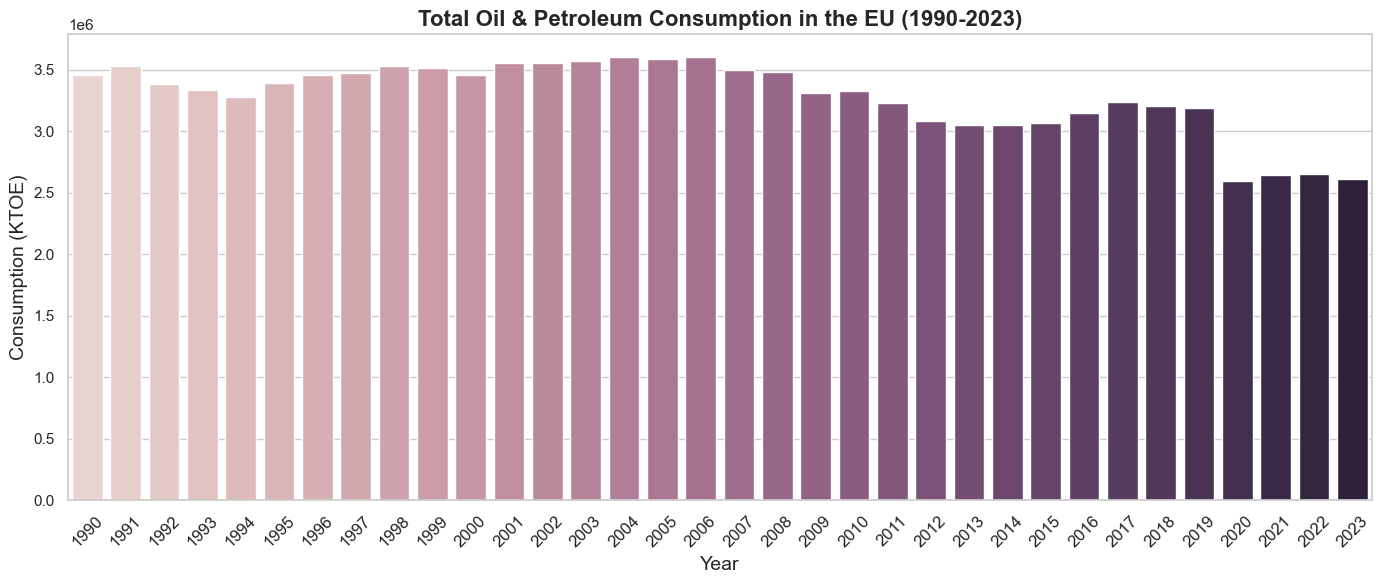

In [26]:
plot_total_consumption(oil_petrol_pivot, "Oil & Petroleum")

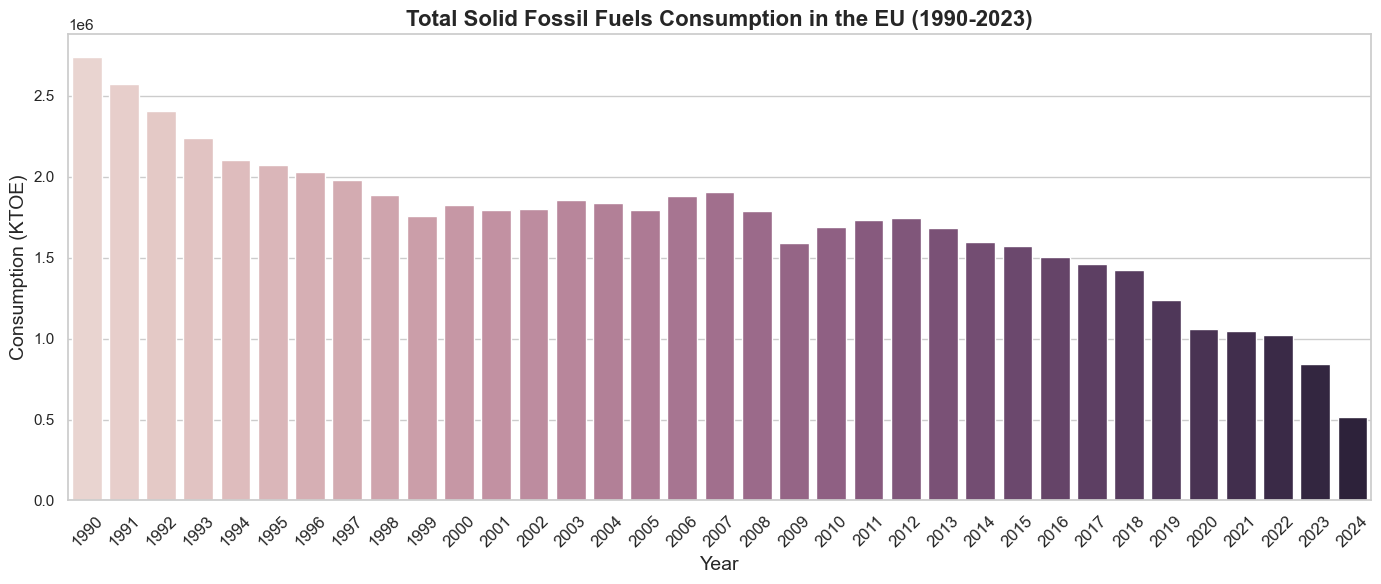

In [27]:
plot_total_consumption(solid_fossil_fuels_pivot, "Solid Fossil Fuels")

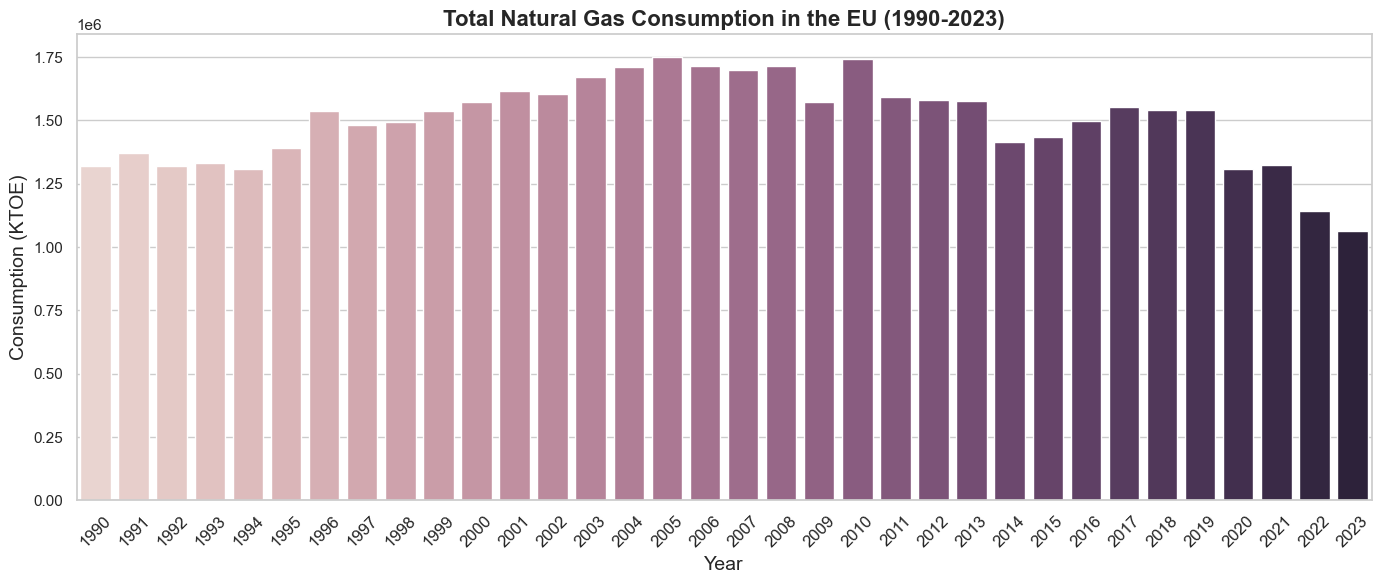

In [28]:
plot_total_consumption(natural_gas_pivot, "Natural Gas")

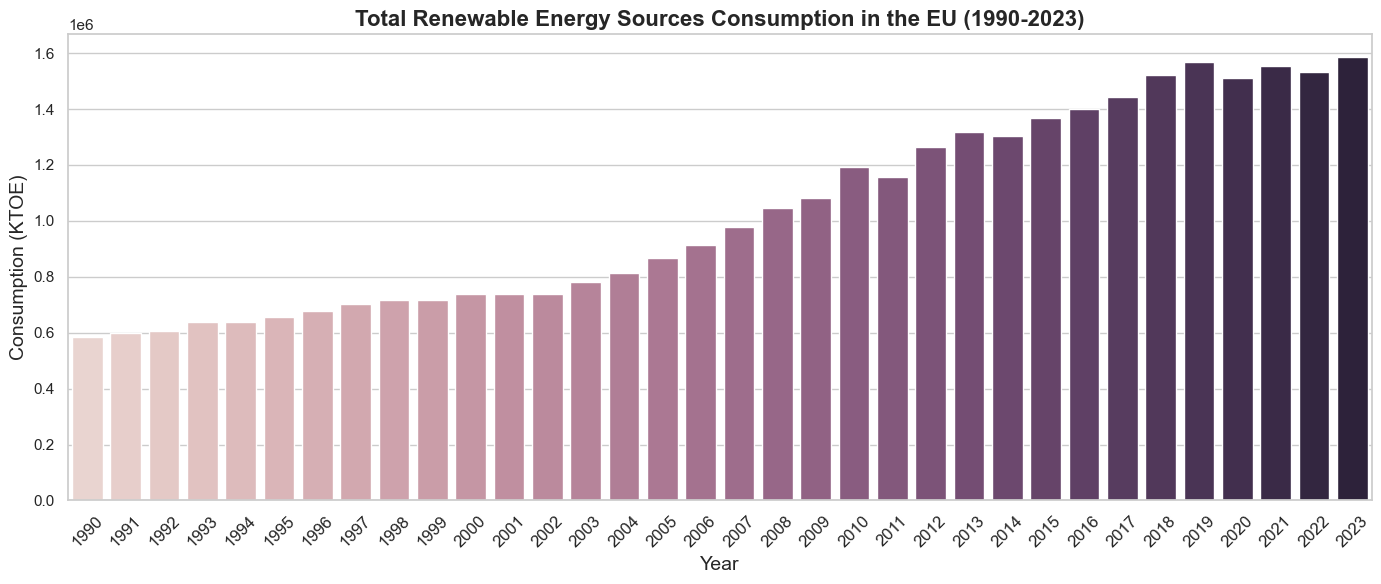

In [29]:
plot_total_consumption(renewables_pivot, "Renewable Energy Sources")

The bar plots reveal a clear structural shift in Europe’s energy consumption mix over the period analysed. Consumption of oil and petroleum declines steadily, indicating a gradual but persistent move away from these fuels. Solid fossil fuels exhibit the most pronounced contraction, with a reduction of approximately 2.1 KTOE between 1990 and 2023, reflecting long-term decarbonisation efforts and the phase-out of coal in many countries. Natural gas shows a non-linear trajectory, characterised by periods of growth followed by a sustained decline from around 2020 onwards, suggesting changing supply conditions and policy-driven demand reductions. In contrast, renewable energy consumption increases consistently across the entire period, rising by roughly 1 KTOE between 1990 and 2023, underscoring the accelerating role of renewables in Europe’s energy transition.

#### Line Plots of Total EU Energy Consumption by Fuel Type (1990-2023)

A combined line plot were created to visualise overall EU energy consumption trends by fuel type from 1990 to 2023. The combined visualisations provide insights into how the EU's energy mix has evolved, highlighting shifts from fossil fuels to renewables and changes in the relative importance of oil, gas, and solid fuels.

The visualisations were created using the cleaned and aggregated `all_energy` dataframe, which contains country-level annual consumption data for all fuel types. The data was grouped by year and fuel type to calculate total EU consumption for each category. 

In [30]:
# Prepare data for plotting
all_energy.head()

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,4884.643,Oil & Petroleum
1,Albania,1991,3349.616,Oil & Petroleum
2,Albania,1992,2540.534,Oil & Petroleum
3,Albania,1993,2469.427,Oil & Petroleum
4,Albania,1994,3099.698,Oil & Petroleum


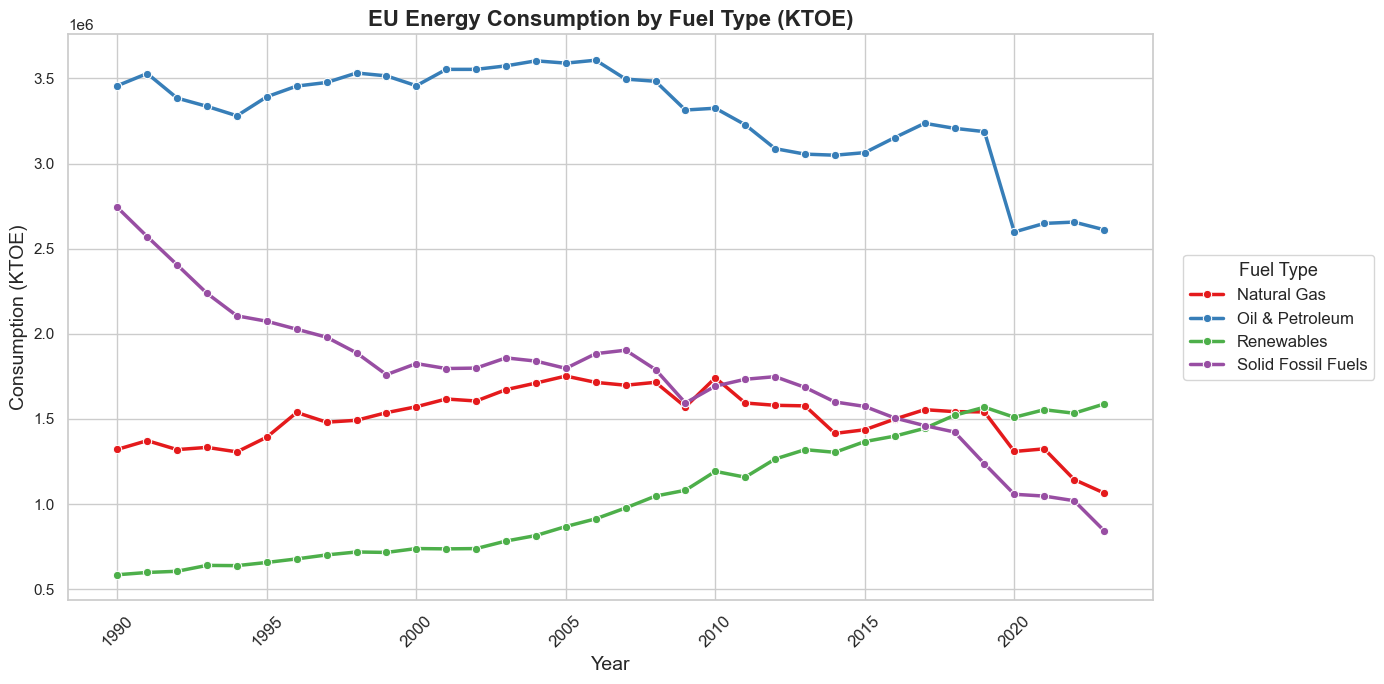

In [31]:
# Group by Year and fuel_type to get total EU consumption
eu_fuel_year = (
    all_energy[all_energy["Year"] < 2024]
    .groupby(['Year', 'fuel_type'], as_index=False)['Consumption_KTOE']
    .sum()
)
plt.figure(figsize=(14,7))

sns.lineplot(
    data=eu_fuel_year,
    x="Year",
    y="Consumption_KTOE",
    hue="fuel_type",
    linewidth=2.5,
    marker="o",
    palette="Set1",
)

plt.title("EU Energy Consumption by Fuel Type (KTOE)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Consumption (KTOE)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Fuel Type", fontsize=12, title_fontsize=13)
# Move legend outside the plot (right side)
plt.legend(
    title="Fuel Type",
    fontsize=12,
    title_fontsize=13,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)
plt.tight_layout()
plt.show()


The comprehensive line plot of EU energy consumption by fuel type, expressed in KTOE per year, illustrates the magnitude of energy resources consumed across European countries over the period analysed. The trajectories of the individual lines enable direct comparison between fuel types and reveal long-term structural shifts in the European energy mix. Overall, the line plot is consistent with the patterns previously observed in the bar charts.

Oil and petroleum consumption exhibit a sustained downward trend, decreasing by approximately 1 KTOE between 1990 and 2023. Solid fossil fuels experience the most pronounced contraction, with consumption falling by around 2.1 KTOE over the same period. Natural gas displays a non-linear trajectory: starting at roughly 1.25 KTOE in 1990, it increases moderately in subsequent years to a peak of about 1.75 KTOE, before declining again and ending the period at approximately 1.1 KTOE per year. This pattern reflects its role as a transitional or “bridge” fuel, offering a more flexible and relatively cleaner alternative to solid fossil fuels. In contrast, renewable energy consumption has increased steadily over the past three decades, largely driven by policy interventions and technological advancements, rising by approximately 1 KTOE in 2023 relative to 1990.

To assess the magnitude of change in fuel type consumption between 1990 and 2023, the `pct_change_absolute()` function is applied to compute percentage changes over the period.

In [32]:
def pct_change_absolute(df, fuel, start_year, end_year):
    total = (
        df[df["fuel_type"] == fuel]
        .groupby("Year")["Consumption_KTOE"]
        .sum()
    )

    return (
        (total.loc[end_year] - total.loc[start_year]) /
        total.loc[start_year] * 100
    )


In [33]:
pct_change_absolute(all_energy, "Oil & Petroleum", 1990, 2023)


-24.464375347186188

In [34]:
pct_change_absolute(all_energy, "Solid Fossil Fuels", 1990, 2023)


-69.20953264445899

In [35]:
pct_change_absolute(all_energy, "Natural Gas", 1990, 2023)

-19.373751539150923

In [36]:
pct_change_absolute(all_energy, "Renewables", 1990, 2023)

171.40029616087787

Between 1990 and 2023, oil and petroleum consumption decreased by approximately 24%, reflecting a gradual reduction in the use of fossil fuels. Solid fossil fuels experienced the most pronounced decline, with consumption dropping by roughly 69%, highlighting a major shift away from coal and related fuels. Natural gas consumption also fell, decreasing by about 19% over the same period, maintaining its role as a transitional energy source. In contrast, renewable energy consumption expanded dramatically, increasing by approximately 171%, underscoring the rapid adoption of clean energy sources across Europe.

To further analyse structural changes in the EU energy system, fuel consumption was expressed as a percentage of total annual EU energy consumption. This allows comparison across fuels and over time, independently of changes in total demand.

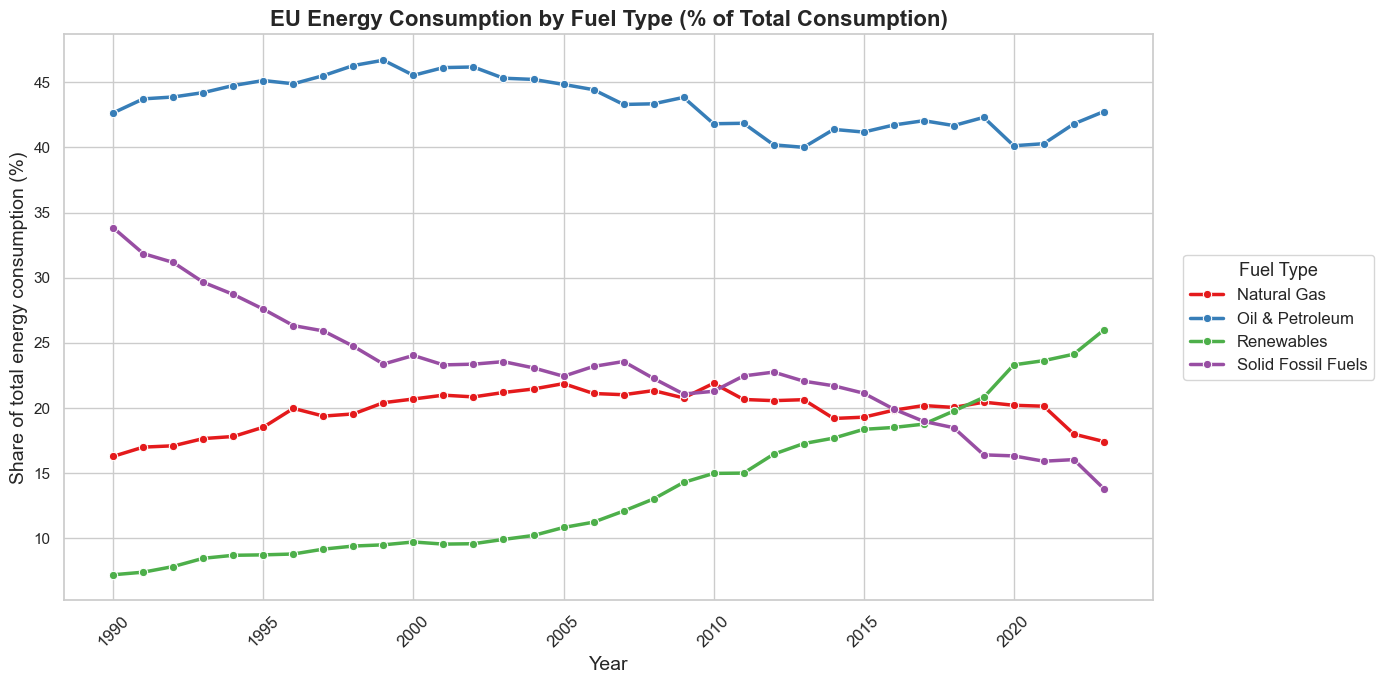

In [37]:
# Total EU energy consumption per year
eu_total = (
    all_energy[all_energy["Year"] < 2024]
    .groupby("Year")["Consumption_KTOE"]
    .sum()
    .reset_index(name="Total_KTOE")
)

# Merge totals and compute percentage share
eu_fuel_share = eu_fuel_year.merge(
    eu_total,
    on="Year",
    how="left"
)

eu_fuel_share["Share_percent"] = (
    eu_fuel_share["Consumption_KTOE"] / eu_fuel_share["Total_KTOE"] * 100
)

# Line plot of fuel shares
plt.figure(figsize=(14,7))
sns.lineplot(
    data=eu_fuel_share,
    x="Year",
    y="Share_percent",
    hue="fuel_type",
    linewidth=2.5,
    marker="o",
    palette="Set1",
)

plt.title("EU Energy Consumption by Fuel Type (% of Total Consumption)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel("Share of total energy consumption (%)", fontsize=14)
plt.legend(title="Fuel Type", fontsize=12, title_fontsize=13)
plt.legend(
    title="Fuel Type",
    fontsize=12,
    title_fontsize=13,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)
plt.tight_layout()
plt.show()



The relative percentage shares of total energy consumption across the four fuel types analysed reflect the structural changes discussed earlier. Although the share of oil and petroleum appears relatively stable over the past three decades, it has followed a gradual downward trend, particularly after 2009. The contribution of solid fossil fuels to the EU’s total energy mix has declined consistently, decreasing by approximately 20 percentage points relative to 1990. Natural gas has maintained a comparatively stable share within the energy mix over time, reinforcing its role as a transitional fuel.

In contrast, renewable energy sources have gained increasing prominence, registering an increase of around 20 percentage points in their share of total consumption. This growth reflects both the expansion of renewable capacity and the broader adoption of these technologies across European countries, alongside the progressive phase-out of solid fossil fuels.

### 3.2 Geospatial Visualization of Fuel Consumption in the EU (2015-2023)

This section presents a geospatial analysis of energy consumption across European countries using choropleth maps derived from [Natural Earth](https://www.naturalearthdata.com/) data to visualise spatial patterns in fuel use. Particular attention is given to ensuring consistency between statistical and spatial datasets, including the harmonisation of country names and the exclusion of overseas territories that do not belong to the European energy system under analysis.

The analysis begins by loading the global map from Natural Earth using 110 m resolution boundaries. Potential mismatches between country names in the energy dataset and the spatial data, as well as missing countries, are identified using the `check_country_mismatches()` function. A mapping dictionary is then created to resolve these discrepancies.

To prepare the data for visualisation, the `prepare_map_data()` function aggregates average fuel consumption values at the country level. The `prepare_europe_map()` function subsequently filters the spatial data to retain only European countries present in the dataset, while excluding overseas territories. Finally, the `build_geo_energy_map()` function integrates these steps into a single data-processing pipeline that harmonises country names, prepares the spatial data, and generates the final map. The resulting dataframe is visualised using the `plot_fuel_map()` function to produce a geospatial representation of EU fuel consumption.

In [38]:
# Load world shapefile
world = gpd.read_file(
    "ne_110m_admin_0_countries.shp"
)

In [39]:
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.067, 180 -16.555, 179...."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.904 -0.95, 34.073 -1.0598, 37.699..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.6656 27.656, -8.6651 27.589, -8.6..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97 49.003, -1..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.03 4..."


In [40]:
def check_country_mismatches(world_gdf, data_df, country_col="Country"):
    """
    Prints countries present in the energy data but missing from the map dataset.
    """
    map_countries = set(world_gdf["ADMIN"].unique())
    data_countries = set(data_df[country_col].unique())

    missing = data_countries - map_countries

    if missing:
        print("Countries not directly matched in map:")
        for c in missing:
            print(f"\nEnergy country: {c}")
            print(
                world_gdf[
                    world_gdf["ADMIN"].str.contains(c.split()[0], case=False, na=False)
                ]["ADMIN"].unique()
            )
    else:
        print("No country mismatches found.")


In [41]:
# Check mismatches
check_country_mismatches(world,oil_petrol_clean)

Countries not directly matched in map:

Energy country: Malta
[]

Energy country: Kosovo*
['Kosovo']

Energy country: Serbia
['Republic of Serbia']

Energy country: Türkiye
[]


In [42]:
# Create a mapping dictionary
COUNTRY_NAME_MAP = {
    "Serbia": "Republic of Serbia",
    "Kosovo*": "Kosovo",
    "Türkiye": "Turkey"
}

In [43]:
def prepare_map_data(df, start_year=2015, end_year=2023):
    """
    Aggregates average fuel consumption per country for mapping.
    """
    map_data = (
        df.query("Year >= @start_year and Year <= @end_year")
          .groupby("Country", as_index=False)["Consumption_KTOE"]
          .mean()
    )

    map_data["Country_map"] = map_data["Country"].replace(COUNTRY_NAME_MAP)
    return map_data


In [44]:
def prepare_europe_map(world_gdf, countries):
    """
    Returns a clean Europe-only map without overseas territories.
    """

    # Explode multipolygons (removes French Guiana etc.)
    world_exploded = world_gdf.explode(index_parts=False)

    # Clip to Europe bounding box (define longitude and latitude)
    europe = world_exploded.cx[-25:45, 34:72]

    # Keep only countries in analysis
    europe = europe[europe["ADMIN"].isin(countries)]

    return europe


In [45]:
def build_geo_energy_map(world_gdf, fuel_df):
    """
    Full pipeline: prepare data, harmonise names, merge with map.
    """
    map_data = prepare_map_data(fuel_df)

    harmonised_countries = set(map_data["Country_map"].unique())
    europe_map = prepare_europe_map(world_gdf, harmonised_countries)

    geo_energy = europe_map.merge(
        map_data,
        left_on="ADMIN",
        right_on="Country_map",
        how="left"
    )

    return geo_energy


In [46]:
def plot_fuel_map(geo_df, fuel_name, cmap="rocket_r"):
    fig, ax = plt.subplots(figsize=(10, 8))

    geo_df.plot(
        column="Consumption_KTOE",
        cmap=cmap,
        linewidth=0.5,
        edgecolor="0.6",
        legend=True,
        ax=ax,
        legend_kwds={
            "label": "Consumption (KTOE/year)",
            "shrink": 0.7
        },
        missing_kwds={
            "color": "lightgrey",
            "label": "No data"
        }
    )

    ax.set_title(f"Average {fuel_name} Consumption (2015–2023)", fontsize=16, fontweight="bold")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


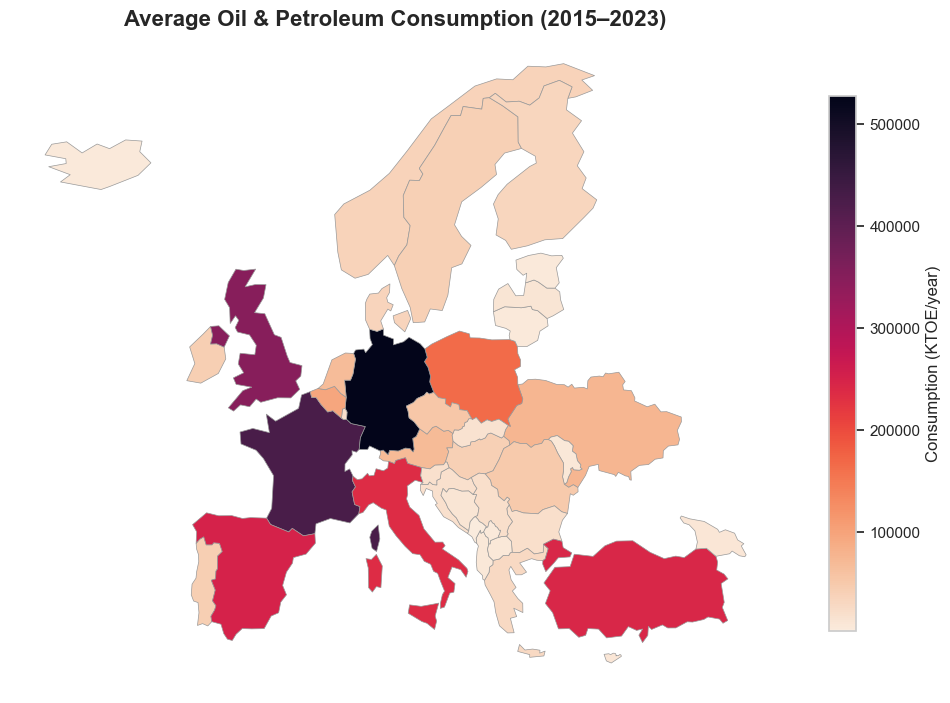

In [47]:
geo_oil = build_geo_energy_map(world, oil_petrol_clean)
plot_fuel_map(geo_oil, "Oil & Petroleum")


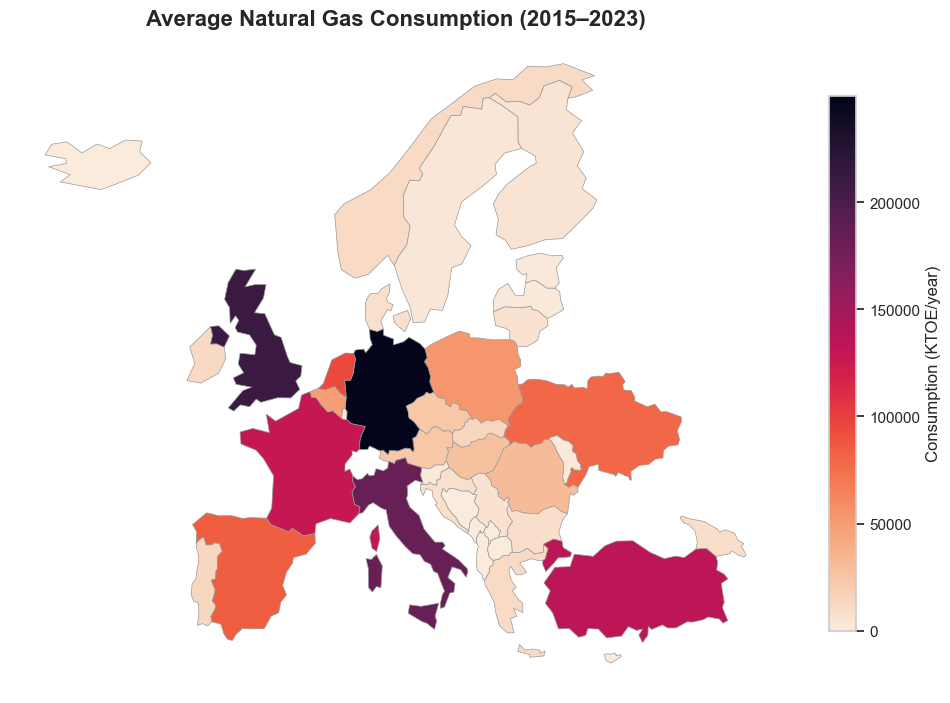

In [48]:

geo_gas = build_geo_energy_map(world, natural_gas_clean)
plot_fuel_map(geo_gas, "Natural Gas")



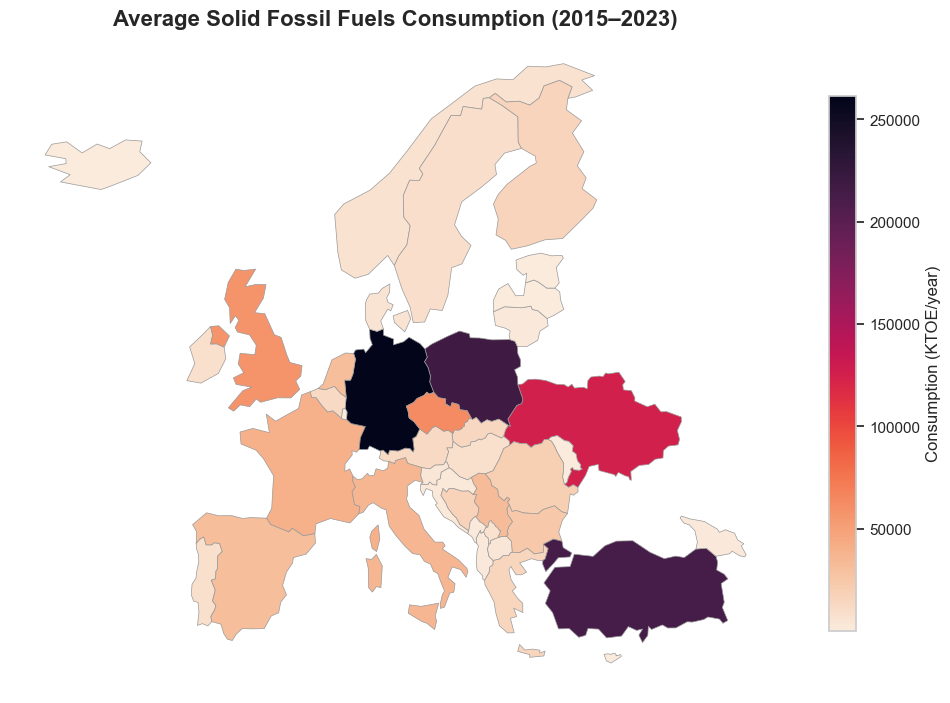

In [49]:

geo_solid = build_geo_energy_map(world, solid_fossil_fuels_clean)
plot_fuel_map(geo_solid, "Solid Fossil Fuels")


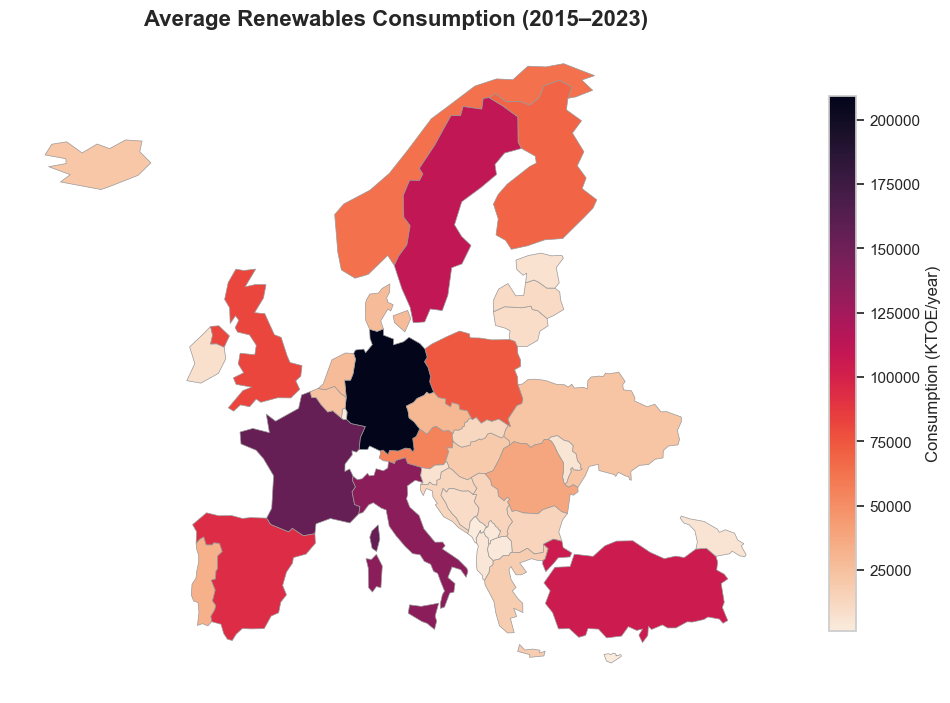

In [50]:

geo_renew = build_geo_energy_map(world, renewables_clean)
plot_fuel_map(geo_renew, "Renewables")

The geospatial plots above display the average annual energy consumption per country for the years 2015 to 2023, highlighting the adoption of the four fuel types across Europe. These visualizations clearly illustrate regional differences between Western and Eastern Europe. Western and Southern European countries exhibit high consumption of natural gas, oil, and petroleum, alongside a growing adoption of renewable energy, while maintaining relatively low levels of solid fossil fuel use. In contrast, the Nordic countries demonstrate a markedly higher reliance on renewables compared with other fuel types. Eastern European countries, together with Turkey, continue to rely more heavily on solid fossil fuels and show comparatively lower adoption of renewables relative to their Western counterparts. Germany stands out for its substantial consumption across all four fuel types, reflecting a diversified energy portfolio.

### 3.3 Country-Level Comparative Analysis

Country-level comparisons are restricted to countries with sufficient data completeness, as defined in Section 2. Countries with more than 20% missing years were excluded from comparative visualisations to avoid biased comparisons.

#### Heatmaps of Top 10 EU Consumers by Fuel Type (1990 - 2023)

Heatmaps were created to visualise the top 10 energy consuming countries for each fuel type over time using the `top_10_heatmap()` function defined below.

In [51]:
def top_10_heatmap(pivot_df, fuel_name, top_n=10):
    """
    Plots a heatmap of the top N energy consuming countries for a given fuel type.
    Parameters:
    -----------
    pivot_df : pd.DataFrame
        Pivot table with countries as rows and years as columns
    fuel_name : str
        Name of the fuel type (used in plot title)
    ax : matplotlib.axes.Axes
        Axes object to plot the heatmap on
    top_n : int
        Number of top consuming countries to display
    """
    # Select top N consumers
    top_countries = pivot_df.sum(axis=1).nlargest(top_n).index
    heatmap_data = pivot_df.loc[top_countries]

    # Plot heatmap
    plt.figure(figsize=(14,7))
    sns.heatmap(
        heatmap_data,
        cmap="rocket_r",
        linewidths=0.3,
        cbar=True,
        cbar_kws={"label": "Consumption (KTOE)"}
    )

    plt.title(f"Top 10 EU {fuel_name} Consumers", fontsize=13, weight="bold")
    plt.xlabel("Year", fontsize=11)
    plt.ylabel("Country", fontsize=11)
    plt.tick_params(axis="x", rotation=45, labelsize=9)
    plt.tick_params(axis="y", labelsize=9)



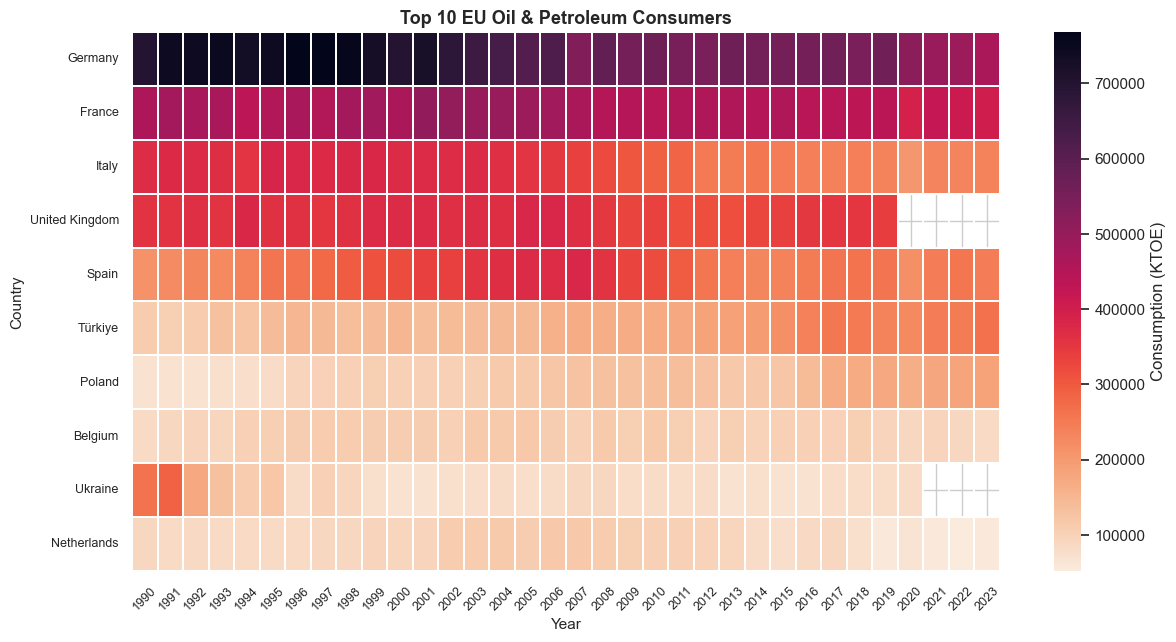

In [52]:
top_10_heatmap(oil_petrol_pivot_fc, "Oil & Petroleum")

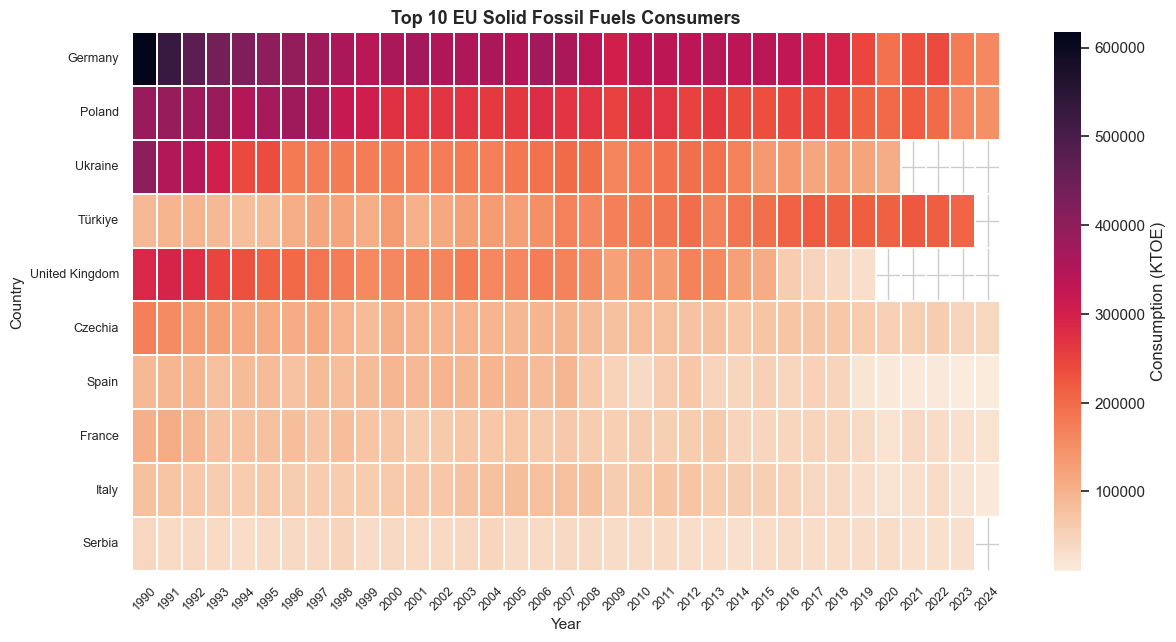

In [53]:
top_10_heatmap(solid_fossil_fuels_pivot_fc, "Solid Fossil Fuels")

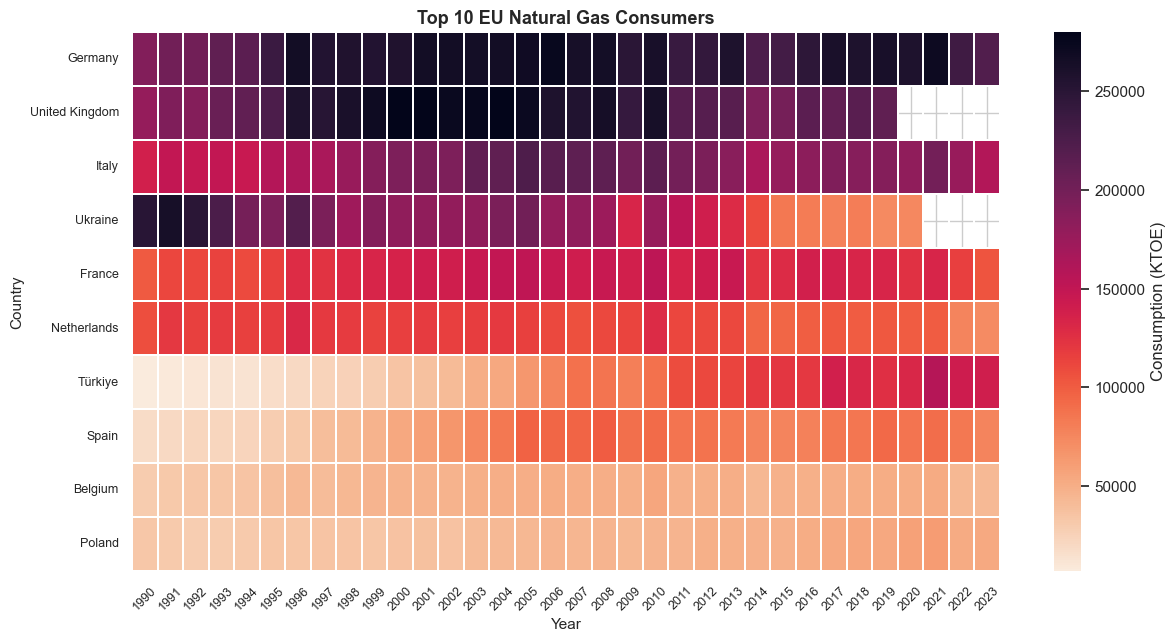

In [54]:
top_10_heatmap(natural_gas_pivot_fc, "Natural Gas")

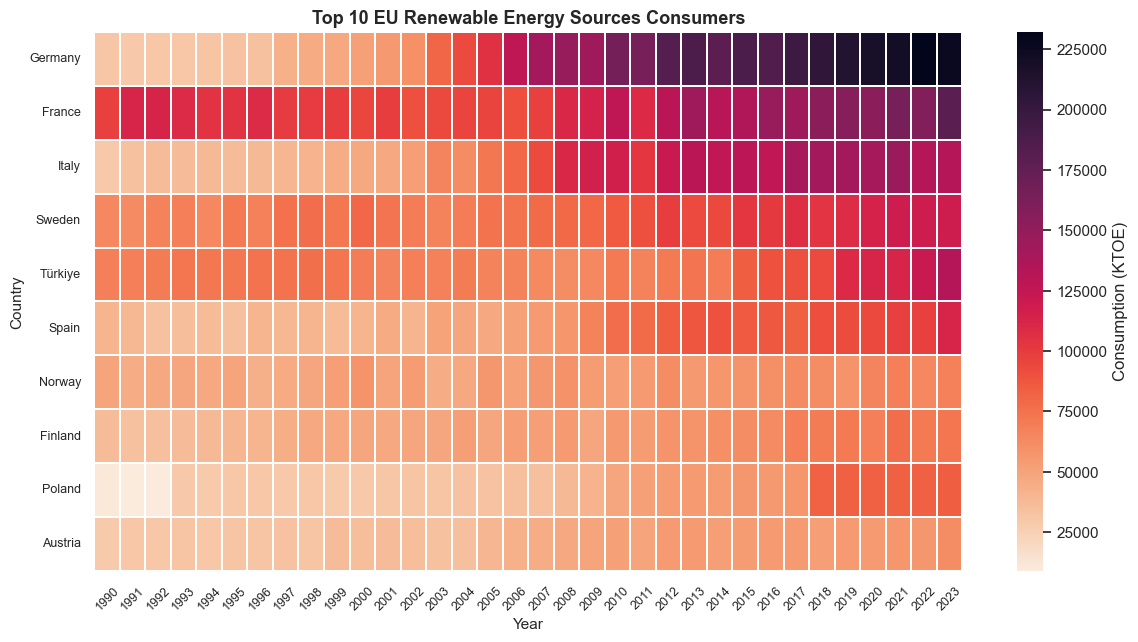

In [55]:
top_10_heatmap(renewables_pivot_fc, "Renewable Energy Sources")

The heatmaps reveal that certain countries consistently rank among the top consumers across multiple fuel types, reflecting their larger economies and higher energy demands. Germany, France, Italy, and Spain, for example, feature prominently in oil, gas, and renewables consumption. Other countries, however, display high consumption in specific fuel types only, highlighting differences in energy profiles and resource availability. The Nordic countries, in particular, rank higher in renewables relative to other fuels, while Germany leads across all four heatmaps, underscoring both its high energy demand and diversified energy portfolio.

It is important to note that UK data is included in these visualizations, as it is present in the Eurostat dataset for the entire study period (1990–2023), despite Brexit in 2020. While some data points are missing post-2020, sufficient coverage exists to retain the UK in the analysis. Similarly, Ukraine has gaps in its dataset for several years due to political instability, but its inclusion remains essential given its historically significant energy consumption within Europe. Incorporating these countries ensures a comprehensive historical assessment of energy consumption trends across the continent.

#### Stacked Bar Plot of National Energy Mix by Fuel Type (2023)

A stacked normalized barplot was created to show the share of total gross available energy consumption by fuel type for each country in 2023. Values were expressed in percentages, so that each country's total energy consumption sums to 100%. This representation allows comparison of national energy structures independently of country size.

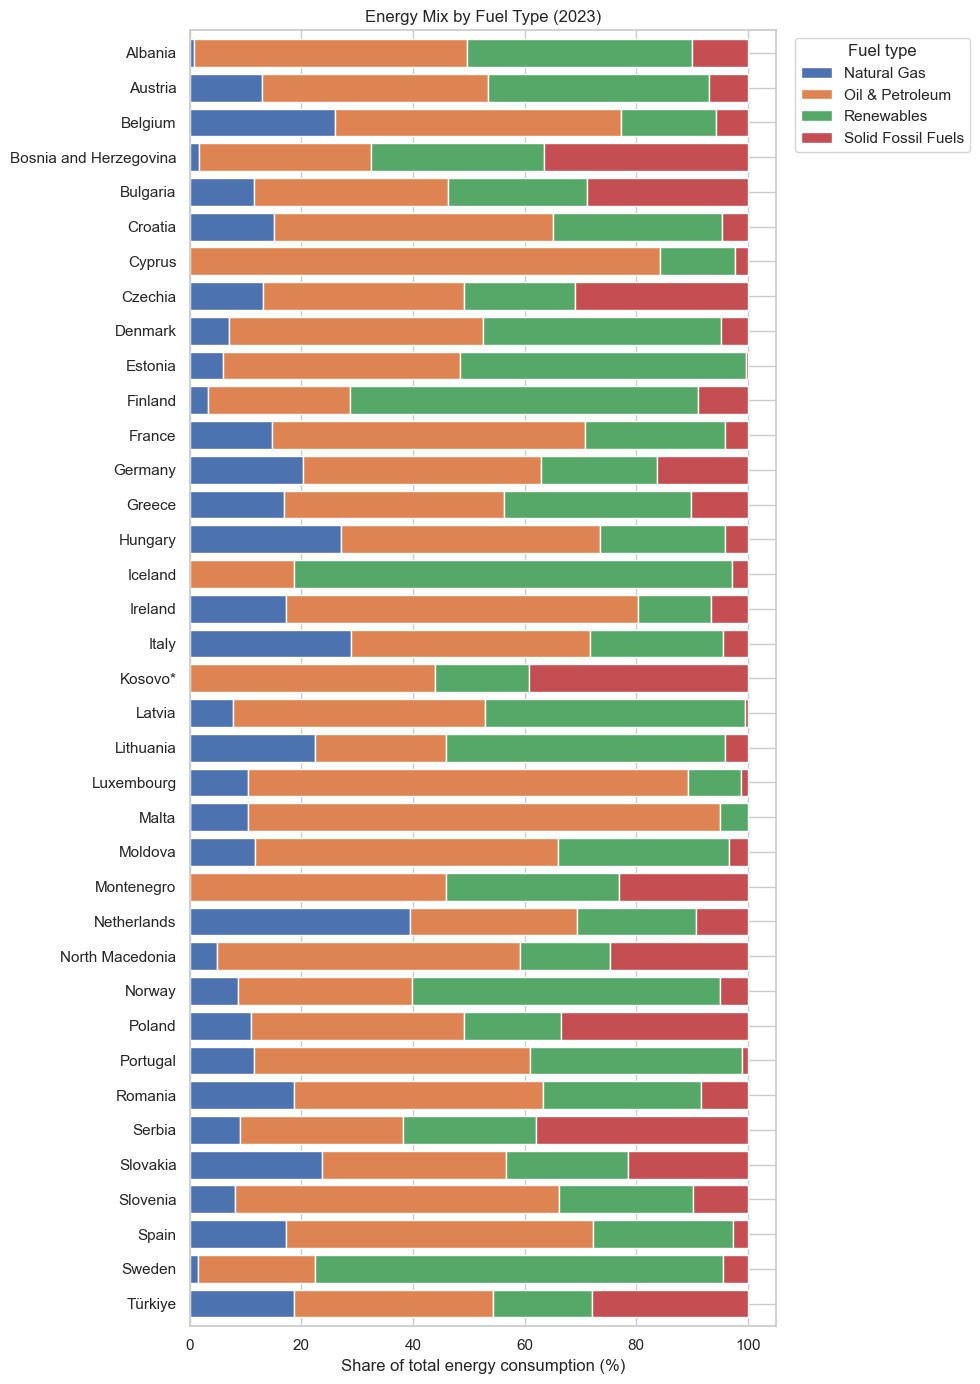

In [56]:
# 1. Filter to 2023
df_2023 = all_energy[all_energy["Year"] == 2023].copy()

# 2. Country totals
totals = (
    df_2023
    .groupby("Country", as_index=False)["Consumption_KTOE"]
    .sum()
    .rename(columns={"Consumption_KTOE": "Total_KTOE"})
)

# 3. Merge totals and compute %
df_2023 = df_2023.merge(totals, on="Country")
df_2023["Share_pct"] = 100 * df_2023["Consumption_KTOE"] / df_2023["Total_KTOE"]

# 4. Pivot for plotting
pivot_pct = (
    df_2023
    .pivot(index="Country", columns="fuel_type", values="Share_pct")
    .fillna(0)
)

# Sort values by country names in alphabetical order
pivot_pct = pivot_pct.sort_values(by= "Country", ascending=False)

# 5. Plot
pivot_pct.plot(
    kind="barh",
    stacked=True,
    figsize=(10, 14),
    width=0.8
)
palette=sns.color_palette("colorblind", as_cmap=True)
plt.xlabel("Share of total energy consumption (%)")
plt.ylabel("")
plt.title("Energy Mix by Fuel Type (2023)")
plt.legend(title="Fuel type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


The figure highlights substantial heterogeneity in national energy mixes across Europe in 2023. Oil and petroleum products remain dominant in many countries, particularly in Southern and Western Europe. However, the relative contribution of oil varies widely, reflecting differences in economic structure, mobility patterns, and energy policy. Notably, Malta, Cyprus, and Luxembourg rely heavily on oil and petroleum.

Solid fossil fuels continue to account for a significant share of energy consumption in certain countries, particularly in parts of Central and Eastern Europe. This pattern reflects historical dependence on coal and related fuels, as well as slower transitions away from carbon-intensive energy sources. Consumption of solid fossil fuels is especially pronounced in Serbia, Kosovo, Czechia, and Bosnia and Herzegovina. Conversely, several countries display relatively low shares of solid fossil fuels, indicating successful phase-out strategies over recent decades.
Natural gas plays an intermediate role across much of Europe, often serving as a transition fuel between coal and renewables. The Netherlands exhibits the highest consumption, followed by Italy and Belgium, highlighting its role as a flexible energy source.

Renewable energy sources contribute a substantial proportion of total consumption in many countries, particularly in Northern Europe and regions with abundant hydro, wind, or biomass resources. These countries demonstrate advanced progress toward decarbonisation and energy diversification, with Sweden, Finland, and Iceland standing out for their impressive share of renewables in the national energy mix.

By presenting energy consumption in relative terms rather than absolute values, this figure emphasizes structural differences in national energy systems. It complements the EU-level trend analysis presented earlier, illustrating how aggregate changes in the EU energy mix emerge from diverse national trajectories.

### 3.4 Energy Consumption by Fuel Type in Ireland (1990-2023)

#### Line Plot of Energy Consumption by Fuel Type in Ireland (KTOE)

This section focuses on a country-level analysis of energy consumption in Ireland, disaggregated by fuel type and measured in kilotonnes of oil equivalent (KTOE) over the period 1990–2023. While previous sections examined aggregate EU trends, this analysis provides a more detailed national perspective, allowing for the identification of country-specific patterns and transitions in the energy mix.

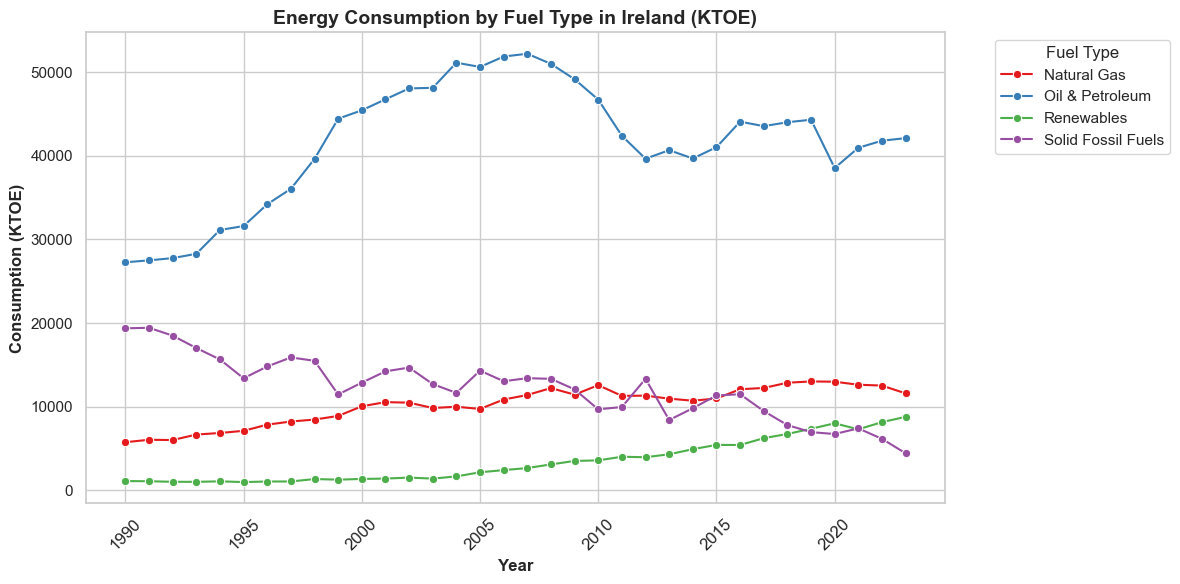

In [73]:
# Filter data for Ireland and exclude 2024
ireland_energy = all_energy[
    (all_energy["Country"] == "Ireland") &
    (all_energy["Year"] <= 2023)
]

# Group by Year and fuel type
ireland_fuel_year = (
    ireland_energy
    .groupby(["Year", "fuel_type"], as_index=False)["Consumption_KTOE"]
    .sum()
)

# Line plot
plt.figure(figsize=(12,6))

sns.lineplot(
    data=ireland_fuel_year,
    x="Year",
    y="Consumption_KTOE",
    hue="fuel_type",
    marker="o",
    palette="Set1",
)
plt.title("Energy Consumption by Fuel Type in Ireland (KTOE)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.xticks(rotation=45, fontsize=12)
plt.ylabel("Consumption (KTOE)", fontsize=12, fontweight="bold")
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [58]:
# Percentage change in Oil and Petroleum consumption
pct_change_absolute(ireland_energy, "Oil & Petroleum", 1990, 2023)

54.47649084625645

In [59]:
# Percentage change in Solid Fossil Fuels consumption
pct_change_absolute(ireland_energy, "Solid Fossil Fuels", 1990, 2023)

-77.174860225302

In [60]:
# Percentage change in Natural Gas consumption
pct_change_absolute(ireland_energy, "Natural Gas", 1990, 2023)

101.67930147745095

In [61]:
# Percentage change in Renewables consumption
pct_change_absolute(ireland_energy, "Renewables", 1990, 2023)

702.9288840743071

Between 1990 and 2023, Ireland’s energy consumption patterns have undergone significant transformations, reflecting a marked shift in the national energy mix. Oil and petroleum consumption increased by approximately 54%, indicating rising demand for liquid fossil fuels, likely driven by transport and industrial needs. In contrast, solid fossil fuels experienced a dramatic decline of roughly 77%, reflecting the near-complete phase-out of coal and other carbon-intensive fuels.

Natural gas consumption more than doubled, increasing by about 102%, underscoring its role as a key transitional energy source supporting both power generation and heating needs. Most strikingly, renewable energy consumption grew by over 700%, highlighting the rapid and sustained adoption of clean energy technologies, including wind, solar, and biomass. This exceptional growth positions renewables as a central component of Ireland’s ongoing energy transition and decarbonisation efforts.


#### Line Plots of Ireland vs EU Average Energy Mix by Fuel Type (% Share)

Line plots were built to compare Ireland's energy mix with the EU average, showing the annual percentage share of each fuel type. Differences between the two lines indicate whether Ireland relies more or less heavily on a given fuel compared to the EU as a whole, while changes over time highlight structural shifts in national and regional energy consumption patterns.

In [77]:
# calculate Ireland's fuel % share
ireland_fuel_share = ireland_fuel_year.merge(
    ireland_fuel_year.groupby("Year")["Consumption_KTOE"]
    .sum()
    .rename("Total_KTOE"),
    on="Year"
)

ireland_fuel_share["Share_percent"] = (
    ireland_fuel_share["Consumption_KTOE"] /
    ireland_fuel_share["Total_KTOE"] * 100
)




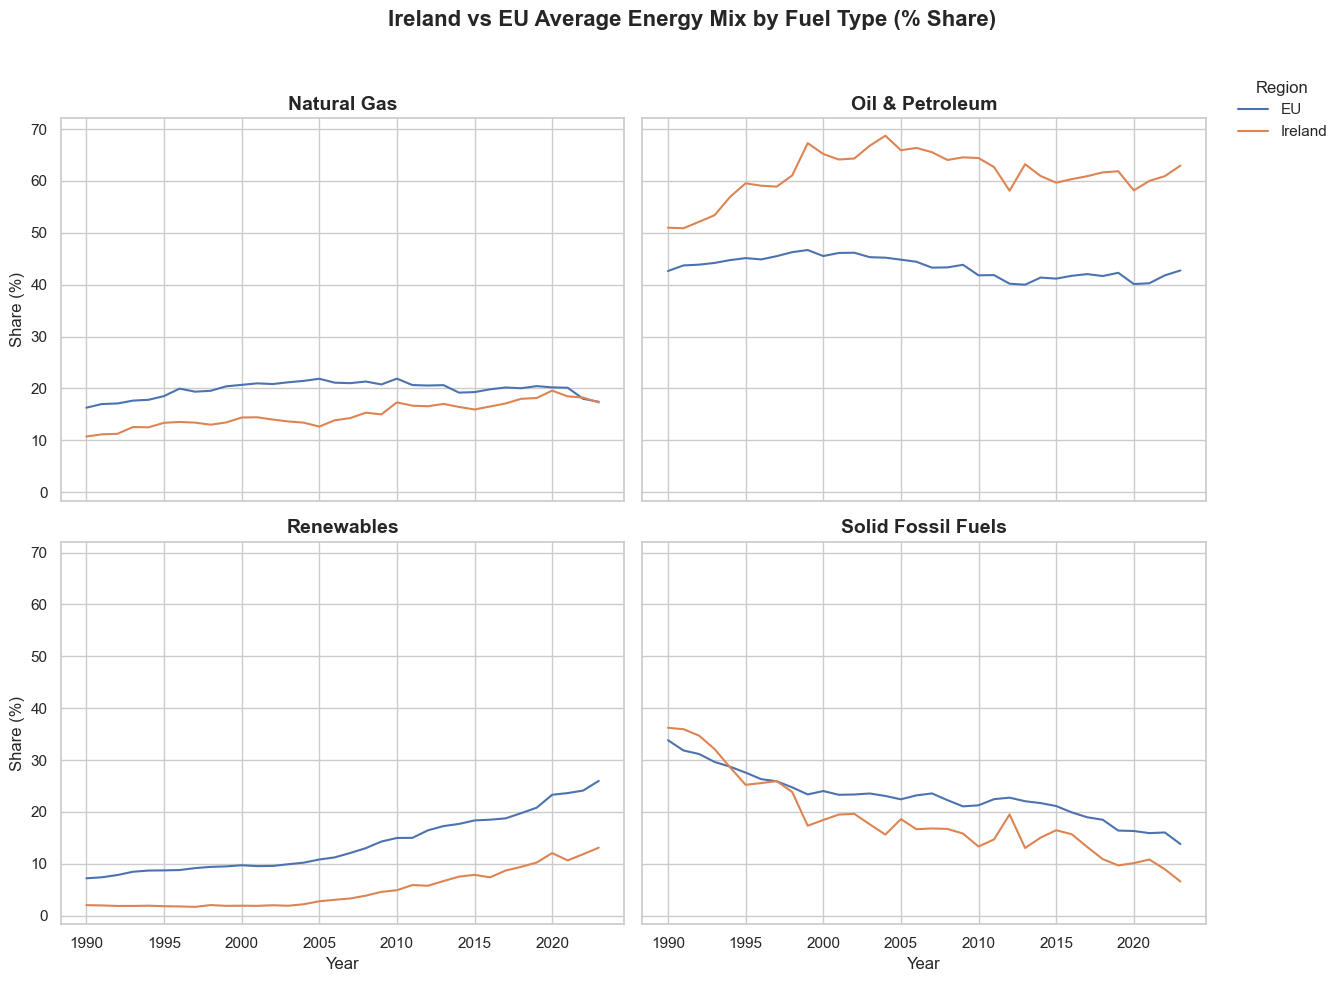

In [101]:
fuel_types = eu_fuel_share["fuel_type"].unique()

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, fuel in zip(axes, fuel_types):
    # EU average
    sns.lineplot(
        data=eu_fuel_share[eu_fuel_share["fuel_type"] == fuel],
        x="Year",
        y="Share_percent",
        ax=ax,
        label="EU",
        legend=False
    )
    # Ireland
    sns.lineplot(
        data=ireland_fuel_share[ireland_fuel_share["fuel_type"] == fuel],
        x="Year",
        y="Share_percent",
        ax=ax,
        label="Ireland",
        legend=False
    )

    ax.set_title(fuel, fontsize=14, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel("Share (%)")
# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Region",
    loc="center left",
    bbox_to_anchor=(0.88, 0.88),
    frameon=False
)
plt.suptitle(
    "Ireland vs EU Average Energy Mix by Fuel Type (% Share)",
    fontsize=16,
    fontweight="bold"
)
# Make space for legend
plt.tight_layout(rect=[0, 0, 0.88, 0.95])
plt.savefig("Ireland vs EU Average Energy Mix by Fuel Type (% Share).png", dpi=300)
plt.show()



Ireland’s energy strategy broadly aligns with the EU’s overall direction, particularly in the transition away from solid fossil fuels and the growth of renewable energy. However, the trends for natural gas and oil and petroleum differ somewhat from the EU average. Throughout the period analyzed, Ireland has consistently consumed more oil and petroleum than the EU average, although both Ireland and the EU show a gradual decline in these fuels. The use of solid fossil fuels in Ireland has steadily decreased, mirroring the EU trend. For most fuel types, Ireland’s share remains below the EU average, except for oil and petroleum. Renewable energy sources are steadily increasing, while natural gas consumption has grown consistently and reached the EU average by 2023.

## 4. Conclusion

Between 1990 and 2023, Europe’s energy system has undergone a significant transition toward cleaner sources. Across the EU, solid fossil fuel consumption declined by 69%, oil and petroleum by 24%, natural gas by 19%, while renewables surged by 171%, reflecting the growing impact of climate policies and the shift toward a low-carbon energy system.
Across Europe, energy mixes remain heterogeneous. Oil dominates in Southern and Western Europe, particularly Malta, Cyprus, and Luxembourg. Solid fossil fuels are still significant in parts of Central and Eastern Europe, including Serbia, Kosovo, Czechia, and Bosnia and Herzegovina. Natural gas serves as a transition fuel in countries like the Netherlands, Italy, and Belgium, while Northern European nations—especially Sweden, Finland, and Iceland—lead in renewable adoption.

Ireland’s energy trajectory largely mirrors this broader European trend, particularly in the steady reduction of solid fossil fuels, which fell by 77%, and the rapid expansion of renewable energy, which increased by 700%. However, Ireland’s path is distinctive in several respects: oil and petroleum consumption increased by 54%, natural gas use doubled (102%), and Ireland has consistently consumed more oil and petroleum than the EU average. By 2023, natural gas consumption in Ireland had reached the EU average, while renewable energy continues its rapid rise.
Despite these advances, Ireland remains heavily reliant on imported fuels, underscoring the persistent challenges of energy security and the ongoing need to transition toward a more resilient, low-carbon energy system.

### End